In [ ]:
# Phase 1: Environment Setup & Data Preparation
!sudo apt install tesseract-ocr
!pip install pytesseract opencv-python pandas numpy matplotlib seaborn pillow scikit-learn torch torchvision torch_geometric

import zipfile
import os
import pandas as pd
import numpy as np
import cv2
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from datetime import datetime, timedelta
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import warnings
warnings.filterwarnings('ignore')

# For file upload from local system
from google.colab import files
import io

print("All libraries installed successfully!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.1 MB/s eta 0:00:00
All libraries installed successfully!


In [ ]:
# Upload zip file from local system
print("Please upload your dataset.zip file...")
uploaded = files.upload()

# Get the uploaded filename
zip_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {zip_filename}")

# Extract the dataset
def extract_dataset(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
    # List extracted contents
    extracted_folders = os.listdir(extract_path)
    print(f"Extracted folders: {extracted_folders}")

extract_path = '/content/dataset'
extract_dataset(zip_filename, extract_path)

# Explore dataset structure
def explore_dataset(base_path):
    real_path = os.path.join(base_path, 'Real_preprocessed')
    fake_path = os.path.join(base_path, 'Fake_preprocessed')

    # Check if folders exist
    if not os.path.exists(real_path):
        # Try to find the real folder with different capitalization
        folders = os.listdir(base_path)
        real_folder = [f for f in folders if 'real' in f.lower()]
        fake_folder = [f for f in folders if 'fake' in f.lower()]

        if real_folder:
            real_path = os.path.join(base_path, real_folder[0])
        if fake_folder:
            fake_path = os.path.join(base_path, fake_folder[0])

    real_images = [f for f in os.listdir(real_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(real_path) else []
    fake_images = [f for f in os.listdir(fake_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(fake_path) else []

    print(f"Real images: {len(real_images)}")
    print(f"Fake images: {len(fake_images)}")

    # Show some sample images
    if real_images:
        print(f"Sample real images: {real_images[:3]}")
    if fake_images:
        print(f"Sample fake images: {fake_images[:3]}")

    return real_path, fake_path, real_images, fake_images

base_path = '/content/dataset'
real_path, fake_path, real_images, fake_images = explore_dataset(base_path)

# Create DataFrame with labels
def create_dataset_df(real_path, fake_path, real_images, fake_images):
    data = []

    # Add real images
    for img in real_images:
        data.append({
            'image_path': os.path.join(real_path, img),
            'image_name': img,
            'label': 0,  # 0 = Real
            'label_text': 'real'
        })

    # Add fake images
    for img in fake_images:
        data.append({
            'image_path': os.path.join(fake_path, img),
            'image_name': img,
            'label': 1,  # 1 = Fake
            'label_text': 'fake'
        })

    return pd.DataFrame(data)

df = create_dataset_df(real_path, fake_path, real_images, fake_images)
print(f"Total dataset size: {len(df)}")
print(df['label_text'].value_counts())

# Display dataset info
print("\nDataset Information:")
print(f"Real documents: {len(real_images)}")
print(f"Fake documents: {len(fake_images)}")
print(f"Total documents: {len(df)}")

# Split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"\nTraining set: {len(train_df)}")
print(f"Test set: {len(test_df)}")

# Display first few rows
print("\nFirst few rows of dataset:")
print(df.head())

Please upload your dataset.zip file...


Saving dataset.zip to dataset.zip
Uploaded file: dataset.zip
Dataset extracted successfully!
Extracted folders: ['Real_preprocessed', 'Fake_preprocessed']
Real images: 360
Fake images: 429
Sample real images: ['real_processed_191.jpg', 'real_processed_109.jpg', 'real_processed_352.jpg']
Sample fake images: ['processed_fake_0_650.jpg', 'processed_fake_0_1663.jpg', 'processed_fake_0_547.jpg']
Total dataset size: 789
label_text
fake    429
real    360
Name: count, dtype: int64

Dataset Information:
Real documents: 360
Fake documents: 429
Total documents: 789

Training set: 631
Test set: 158

First few rows of dataset:
                                          image_path              image_name  \
0  /content/dataset/Real_preprocessed/real_proces...  real_processed_191.jpg   
1  /content/dataset/Real_preprocessed/real_proces...  real_processed_109.jpg   
2  /content/dataset/Real_preprocessed/real_proces...  real_processed_352.jpg   
3  /content/dataset/Real_preprocessed/real_proces...  rea

Displaying sample images from dataset...


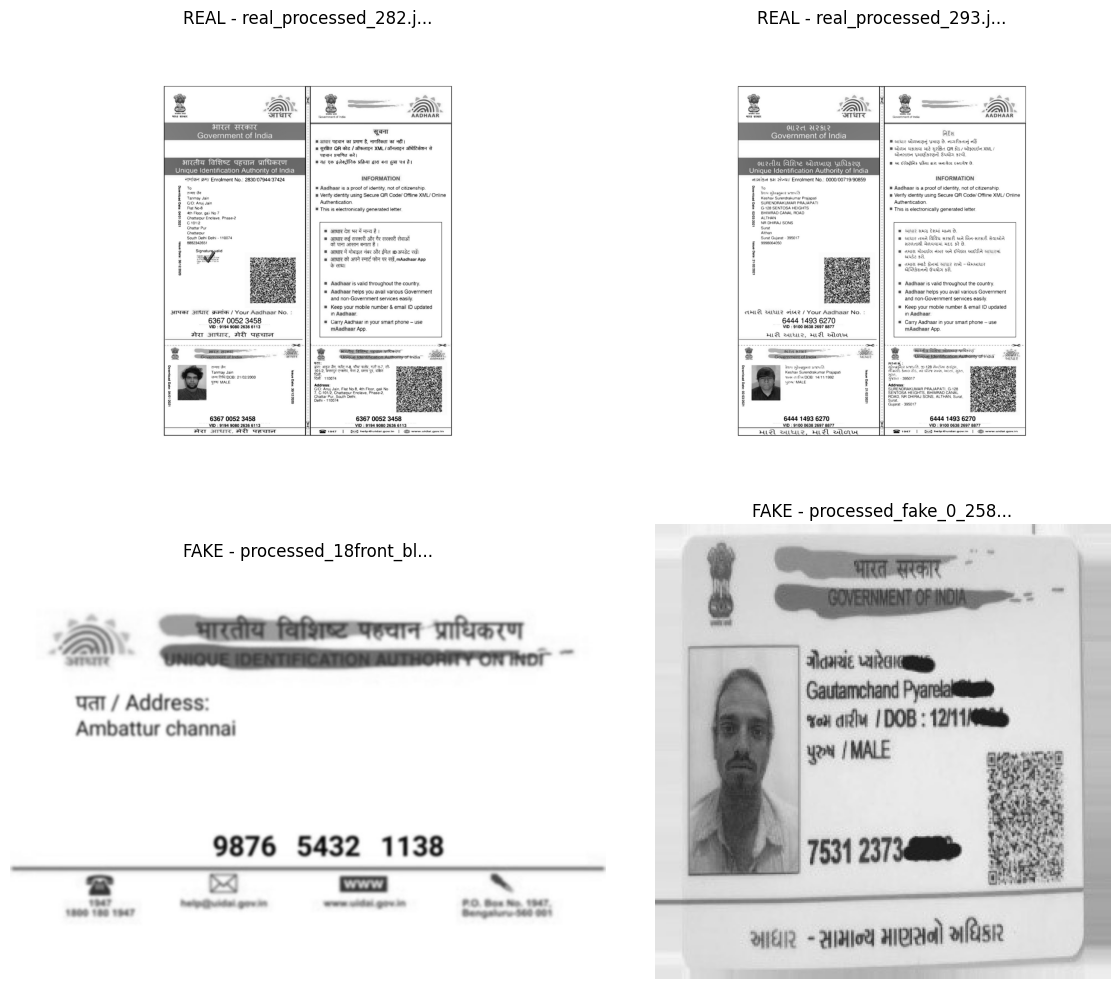

In [ ]:
# Function to display sample images
def display_sample_images(df, num_samples=4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    # Get samples from real and fake
    real_samples = df[df['label'] == 0].sample(num_samples//2, random_state=42)
    fake_samples = df[df['label'] == 1].sample(num_samples//2, random_state=42)
    samples = pd.concat([real_samples, fake_samples])

    for idx, (_, row) in enumerate(samples.iterrows()):
        try:
            img = cv2.imread(row['image_path'])
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"{row['label_text'].upper()} - {row['image_name'][:20]}...")
            axes[idx].axis('off')
        except Exception as e:
            print(f"Error displaying image {row['image_path']}: {e}")
            axes[idx].text(0.5, 0.5, 'Error loading image',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[idx].transAxes)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
print("Displaying sample images from dataset...")
display_sample_images(df)

In [ ]:
# Phase 2: Advanced OCR & Text Extraction (Your existing code)
class AadhaarOCRProcessor:
    def __init__(self):
        self.essential_elements = [
            'government of india', 'uidai', 'aadhaar', 'unique identification authority of india'
        ]

    # ... your existing methods continue ...

# === ADD THE IMPROVED CODE RIGHT HERE ===

# Improved OCR Processor with better text cleaning
class ImprovedAadhaarOCRProcessor:
    def __init__(self):
        self.essential_elements = [
            'government of india', 'uidai', 'aadhaar', 'unique identification authority of india'
        ]

    def extract_text_improved(self, image_path):
        """Improved OCR with better preprocessing"""
        try:
            img = cv2.imread(image_path)
            if img is None:
                return ""

            # Multiple preprocessing techniques
            # 1. Resize for better OCR
            height, width = img.shape[:2]
            if width > 1000:
                scale = 1000 / width
                img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

            # 2. Multiple preprocessing filters
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Try different preprocessing methods
            methods = [
                gray,
                cv2.GaussianBlur(gray, (5, 5), 0),
                cv2.medianBlur(gray, 3),
                cv2.bilateralFilter(gray, 9, 75, 75)
            ]

            best_text = ""
            for processed_img in methods:
                # Try multiple OCR configurations
                configs = [
                    r'--oem 3 --psm 6',
                    r'--oem 3 --psm 11',
                    r'--oem 3 --psm 4',
                    r'--oem 3 --psm 8'
                ]

                for config in configs:
                    text = pytesseract.image_to_string(processed_img, config=config, lang='eng')
                    if len(text.strip()) > len(best_text.strip()):
                        best_text = text

            return best_text
        except Exception as e:
            print(f"OCR Error: {e}")
            return ""

    def validate_aadhaar_improved(self, text):
        """Better AADHAAR number validation"""
        # Look for 12-digit patterns with various spacings
        patterns = [
            r'\b\d{4}\s?\d{4}\s?\d{4}\b',
            r'\b\d{12}\b',
            r'\b\d{4}-\d{4}-\d{4}\b'
        ]

        for pattern in patterns:
            matches = re.findall(pattern, text)
            for match in matches:
                aadhaar_clean = re.sub(r'[^\d]', '', match)
                if len(aadhaar_clean) == 12:
                    return True, aadhaar_clean
        return False, None

    def detect_essential_elements_improved(self, text):
        """More flexible essential element detection"""
        detected = []
        text_lower = text.lower()

        # Flexible matching for common variations
        elements_flexible = {
            'government of india': ['government of india', 'govt of india', 'government india'],
            'uidai': ['uidai', 'unique identification authority', 'unique id authority'],
            'aadhaar': ['aadhaar', 'aadhar', 'aadhar card', 'aadhaar card'],
            'india': ['india', 'indian', 'government of india']
        }

        for element, variations in elements_flexible.items():
            for variation in variations:
                if variation in text_lower:
                    detected.append(element)
                    break
        return detected

    def process_aadhaar_document_improved(self, image_path):
        """Improved document processing"""
        text = self.extract_text_improved(image_path)
        aadhaar_valid, aadhaar_number = self.validate_aadhaar_improved(text)

        result = {
            'raw_text': text,
            'aadhaar_number': aadhaar_number,
            'aadhaar_valid': aadhaar_valid,
            'essential_elements_detected': self.detect_essential_elements_improved(text),
            'has_government_text': any(gov in text.lower() for gov in ['government of india', 'govt of india']),
            'has_uidai_text': any(uidai in text.lower() for uidai in ['uidai', 'unique identification authority']),
            'text_length': len(text)
        }

        return result

# Improved QR Code Detection
def detect_qr_improved(image_path):
    """Better QR code detection"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False

        # Multiple detection methods
        qr_detector = cv2.QRCodeDetector()

        # Method 1: Standard detection
        data, bbox, _ = qr_detector.detectAndDecode(img)
        if bbox is not None:
            return True

        # Method 2: Look for square patterns that could be QR codes
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)

        # Look for square contours (QR code characteristic)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
            if len(approx) == 4:  # Square shape
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / h
                if 0.8 < aspect_ratio < 1.2 and 50 < w < 200:  # QR code size range
                    return True
        return False
    except Exception as e:
        print(f"QR Detection Error: {e}")
        return False

# Initialize improved processor
improved_ocr_processor = ImprovedAadhaarOCRProcessor()

# === YOUR EXISTING PHASE 3 CODE CONTINUES HERE ===

In [ ]:
# Improved OCR Processor with better text cleaning
class ImprovedAadhaarOCRProcessor:
    def extract_text_improved(self, image_path):
        """Improved OCR with better preprocessing"""
        img = cv2.imread(image_path)

        # Multiple preprocessing techniques
        # 1. Resize for better OCR
        height, width = img.shape[:2]
        if width > 1000:
            scale = 1000 / width
            img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

        # 2. Multiple preprocessing filters
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Try different preprocessing methods
        methods = [
            gray,
            cv2.GaussianBlur(gray, (5, 5), 0),
            cv2.medianBlur(gray, 3),
            cv2.bilateralFilter(gray, 9, 75, 75)
        ]

        best_text = ""
        for processed_img in methods:
            # Try multiple OCR configurations
            configs = [
                r'--oem 3 --psm 6',
                r'--oem 3 --psm 11',
                r'--oem 3 --psm 4',
                r'--oem 3 --psm 8'
            ]

            for config in configs:
                text = pytesseract.image_to_string(processed_img, config=config, lang='eng')
                if len(text.strip()) > len(best_text.strip()):
                    best_text = text

        return best_text

    def validate_aadhaar_improved(self, text):
        """Better AADHAAR number validation"""
        # Look for 12-digit patterns with various spacings
        patterns = [
            r'\b\d{4}\s?\d{4}\s?\d{4}\b',
            r'\b\d{12}\b',
            r'\b\d{4}-\d{4}-\d{4}\b'
        ]

        for pattern in patterns:
            matches = re.findall(pattern, text)
            for match in matches:
                aadhaar_clean = re.sub(r'[^\d]', '', match)
                if len(aadhaar_clean) == 12:
                    return True, aadhaar_clean
        return False, None

# Improved QR Code Detection
def detect_qr_improved(image_path):
    """Better QR code detection"""
    img = cv2.imread(image_path)

    # Multiple detection methods
    methods = [
        cv2.QRCodeDetector(),
        # Try with different preprocessing
    ]

    for detector in methods:
        try:
            data, bbox, _ = detector.detectAndDecode(img)
            if bbox is not None:
                return True
        except:
            continue

    # Alternative: Look for square patterns that could be QR codes
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Look for square contours (QR code characteristic)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:  # Square shape
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / h
            if 0.8 < aspect_ratio < 1.2 and 50 < w < 200:  # QR code size range
                return True
    return False

In [ ]:
# Phase 3: Computer Vision Analysis

class AadhaarFormatValidator:
    def __init__(self):
        self.required_elements = {
            'qr_code': 0.3,
            'logo': 0.2,
            'security_features': 0.2,
            'proper_layout': 0.3
        }

    def detect_qr_code(self, image_path):
        """Detect QR code in image"""
        try:
            img = cv2.imread(image_path)
            if img is None:
                return False

            # Initialize QR code detector
            qr_detector = cv2.QRCodeDetector()
            data, bbox, _ = qr_detector.detectAndDecode(img)

            return bbox is not None and len(bbox) > 0
        except:
            return False

    def detect_logo(self, image_path):
        """Detect AADHAAR logo (simplified implementation)"""
        try:
            img = cv2.imread(image_path)
            if img is None:
                return False

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Simple template matching for emblem-like features
            # In production, you'd use trained logo detectors
            edges = cv2.Canny(gray, 50, 150)

            # Count edge density in central regions (where logos typically are)
            height, width = edges.shape
            roi = edges[height//10:height//3, width//3:2*width//3]

            edge_density = np.sum(roi > 0) / (roi.shape[0] * roi.shape[1])

            return edge_density > 0.01  # Threshold for logo presence
        except:
            return False

    def analyze_image_quality(self, image_path):
        """Analyze image quality metrics"""
        try:
            img = cv2.imread(image_path)
            if img is None:
                return {'blur_score': 1.0, 'quality_score': 0.0}

            # Calculate blur using Laplacian variance
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()

            # Normalize blur score (higher = less blurry)
            normalized_blur = min(blur_score / 100.0, 1.0)

            # Calculate overall quality score
            quality_score = normalized_blur

            return {
                'blur_score': normalized_blur,
                'quality_score': quality_score
            }
        except:
            return {'blur_score': 0.0, 'quality_score': 0.0}

    def check_layout_consistency(self, image_path):
        """Check if document has proper AADHAAR layout"""
        try:
            img = cv2.imread(image_path)
            if img is None:
                return False

            # Basic aspect ratio check (AADHAAR cards have specific dimensions)
            height, width = img.shape[:2]
            aspect_ratio = width / height

            # AADHAAR cards typically have aspect ratio around 1.5-1.8
            proper_aspect = 1.4 <= aspect_ratio <= 2.0

            # Check for sufficient text regions (simplified)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            text_region_ratio = np.sum(thresh < 128) / (height * width)
            sufficient_text = text_region_ratio > 0.05  # At least 5% text coverage

            return proper_aspect and sufficient_text
        except:
            return False

    def validate_document_format(self, image_path):
        """Comprehensive format validation"""
        qr_detected = self.detect_qr_code(image_path)
        logo_detected = self.detect_logo(image_path)
        quality_metrics = self.analyze_image_quality(image_path)
        proper_layout = self.check_layout_consistency(image_path)

        # Calculate format score
        format_score = (
            self.required_elements['qr_code'] * qr_detected +
            self.required_elements['logo'] * logo_detected +
            self.required_elements['security_features'] * 0.5 +  # Simplified
            self.required_elements['proper_layout'] * proper_layout
        )

        return {
            'qr_detected': qr_detected,
            'logo_detected': logo_detected,
            'blur_score': quality_metrics['blur_score'],
            'quality_score': quality_metrics['quality_score'],
            'proper_layout': proper_layout,
            'format_score': format_score,
            'format_valid': format_score >= 0.6  # Threshold for valid format
        }

# Initialize format validator
format_validator = AadhaarFormatValidator()

In [ ]:
# Phase 4: Multi-Parameter Fraud Scoring System

class AadhaarFraudDetector:
    def __init__(self):
        self.parameter_weights = {
            'text_validation': 0.25,
            'format_validation': 0.25,
            'data_consistency': 0.20,
            'image_quality': 0.15,
            'essential_elements': 0.15
        }

        self.fraud_threshold = 0.6  # Score above which document is considered fraudulent

    def calculate_fraud_score(self, ocr_results, format_results, image_path, label=None):
        """Calculate comprehensive fraud score"""

        # 1. Text Validation Score
        text_score = 0.0
        if not ocr_results['aadhaar_valid']:
            text_score += 0.4
        if len(ocr_results['essential_elements_detected']) < 2:
            text_score += 0.3
        if ocr_results['text_length'] < 50:  # Too little text
            text_score += 0.3

        # 2. Format Validation Score
        format_score = 1.0 - format_results['format_score']

        # 3. Data Consistency Score
        consistency_score = 0.0
        if not format_results['proper_layout']:
            consistency_score += 0.5
        if not format_results['qr_detected']:
            consistency_score += 0.3
        if not format_results['logo_detected']:
            consistency_score += 0.2

        # 4. Image Quality Score
        quality_score = 1.0 - format_results['quality_score']
        if format_results['blur_score'] < 0.3:  # Very blurry
            quality_score = 1.0

        # 5. Essential Elements Score
        elements_score = 1.0 - (len(ocr_results['essential_elements_detected']) / 4.0)

        # Calculate weighted fraud score
        fraud_score = (
            self.parameter_weights['text_validation'] * text_score +
            self.parameter_weights['format_validation'] * format_score +
            self.parameter_weights['data_consistency'] * consistency_score +
            self.parameter_weights['image_quality'] * quality_score +
            self.parameter_weights['essential_elements'] * elements_score
        )

        # Ensure score is between 0 and 1
        fraud_score = min(max(fraud_score, 0.0), 1.0)

        result = {
            'fraud_score': fraud_score,
            'is_fraudulent': fraud_score >= self.fraud_threshold,
            'component_scores': {
                'text_validation': text_score,
                'format_validation': format_score,
                'data_consistency': consistency_score,
                'image_quality': quality_score,
                'essential_elements': elements_score
            },
            'final_prediction': 1 if fraud_score >= self.fraud_threshold else 0
        }

        # Add ground truth if available
        if label is not None:
            result['actual_label'] = label
            result['correct_prediction'] = result['final_prediction'] == label

        return result

# Initialize fraud detector
fraud_detector = AadhaarFraudDetector()

In [ ]:
# Process all images and create results
def process_dataset(df, sample_size=None):
    """Process entire dataset and return results"""
    results = []

    # Process sample if specified
    process_df = df.sample(n=sample_size, random_state=42) if sample_size else df

    for idx, row in process_df.iterrows():
        if idx % 50 == 0:
            print(f"Processing image {idx}/{len(process_df)}")

        try:
            # Perform OCR analysis
            ocr_results = ocr_processor.process_aadhaar_document(row['image_path'])

            # Perform format validation
            format_results = format_validator.validate_document_format(row['image_path'])

            # Calculate fraud score
            fraud_results = fraud_detector.calculate_fraud_score(
                ocr_results, format_results, row['image_path'], row['label']
            )

            # Combine all results
            result = {
                'image_name': row['image_name'],
                'image_path': row['image_path'],
                'actual_label': row['label'],
                'actual_label_text': row['label_text'],
                **ocr_results,
                **format_results,
                **fraud_results
            }

            results.append(result)

        except Exception as e:
            print(f"Error processing {row['image_name']}: {e}")
            continue

    return pd.DataFrame(results)

# Process training data first (small sample for testing)
print("Processing training data...")
sample_results = process_dataset(train_df, sample_size=100)  # Start with small sample

# Display results
print(f"Processed {len(sample_results)} images successfully")
print("\nFraud Detection Performance:")
print(f"Accuracy: {sample_results['correct_prediction'].mean():.2%}")
print(f"Average Fraud Score for Real: {sample_results[sample_results['actual_label'] == 0]['fraud_score'].mean():.3f}")
print(f"Average Fraud Score for Fake: {sample_results[sample_results['actual_label'] == 1]['fraud_score'].mean():.3f}")

# Show detailed results
sample_results[['image_name', 'actual_label_text', 'fraud_score', 'is_fraudulent', 'correct_prediction']].head(10)

Processing training data...
Processing image 600/100
Processing image 650/100
Processing image 450/100
Processing image 0/100
Processed 100 images successfully

Fraud Detection Performance:
Accuracy: 77.00%
Average Fraud Score for Real: 0.551
Average Fraud Score for Fake: 0.652


,image_name,actual_label_text,fraud_score,is_fraudulent,correct_prediction
0,processed_fake_0_1203.jpg,fake,0.7350,True,True
1,processed_fake_0_354.jpg,fake,0.7350,True,True
2,real_processed_229.jpg,real,0.5225,False,True
3,processed_26backside_hue_sat_adjusted.jpg,fake,0.3850,False,False
4,real_processed_164.jpg,real,0.6600,True,False
5,real_processed_224.jpg,real,0.5600,False,True
6,processed_fake_0_753.jpg,fake,0.7350,True,True
7,real_processed_299.jpg,real,0.6600,True,False
8,processed_fake_0_314.jpg,fake,0.7350,True,True
9,processed_fake_0_641.jpg,fake,0.6600,True,True


=== PHASE 5: RESULTS & EXPORT ===
Processing sample data for visualization...
Processing image 300/100
Processing image 450/100
Sample data processed: 100 images
Creating visualizations...


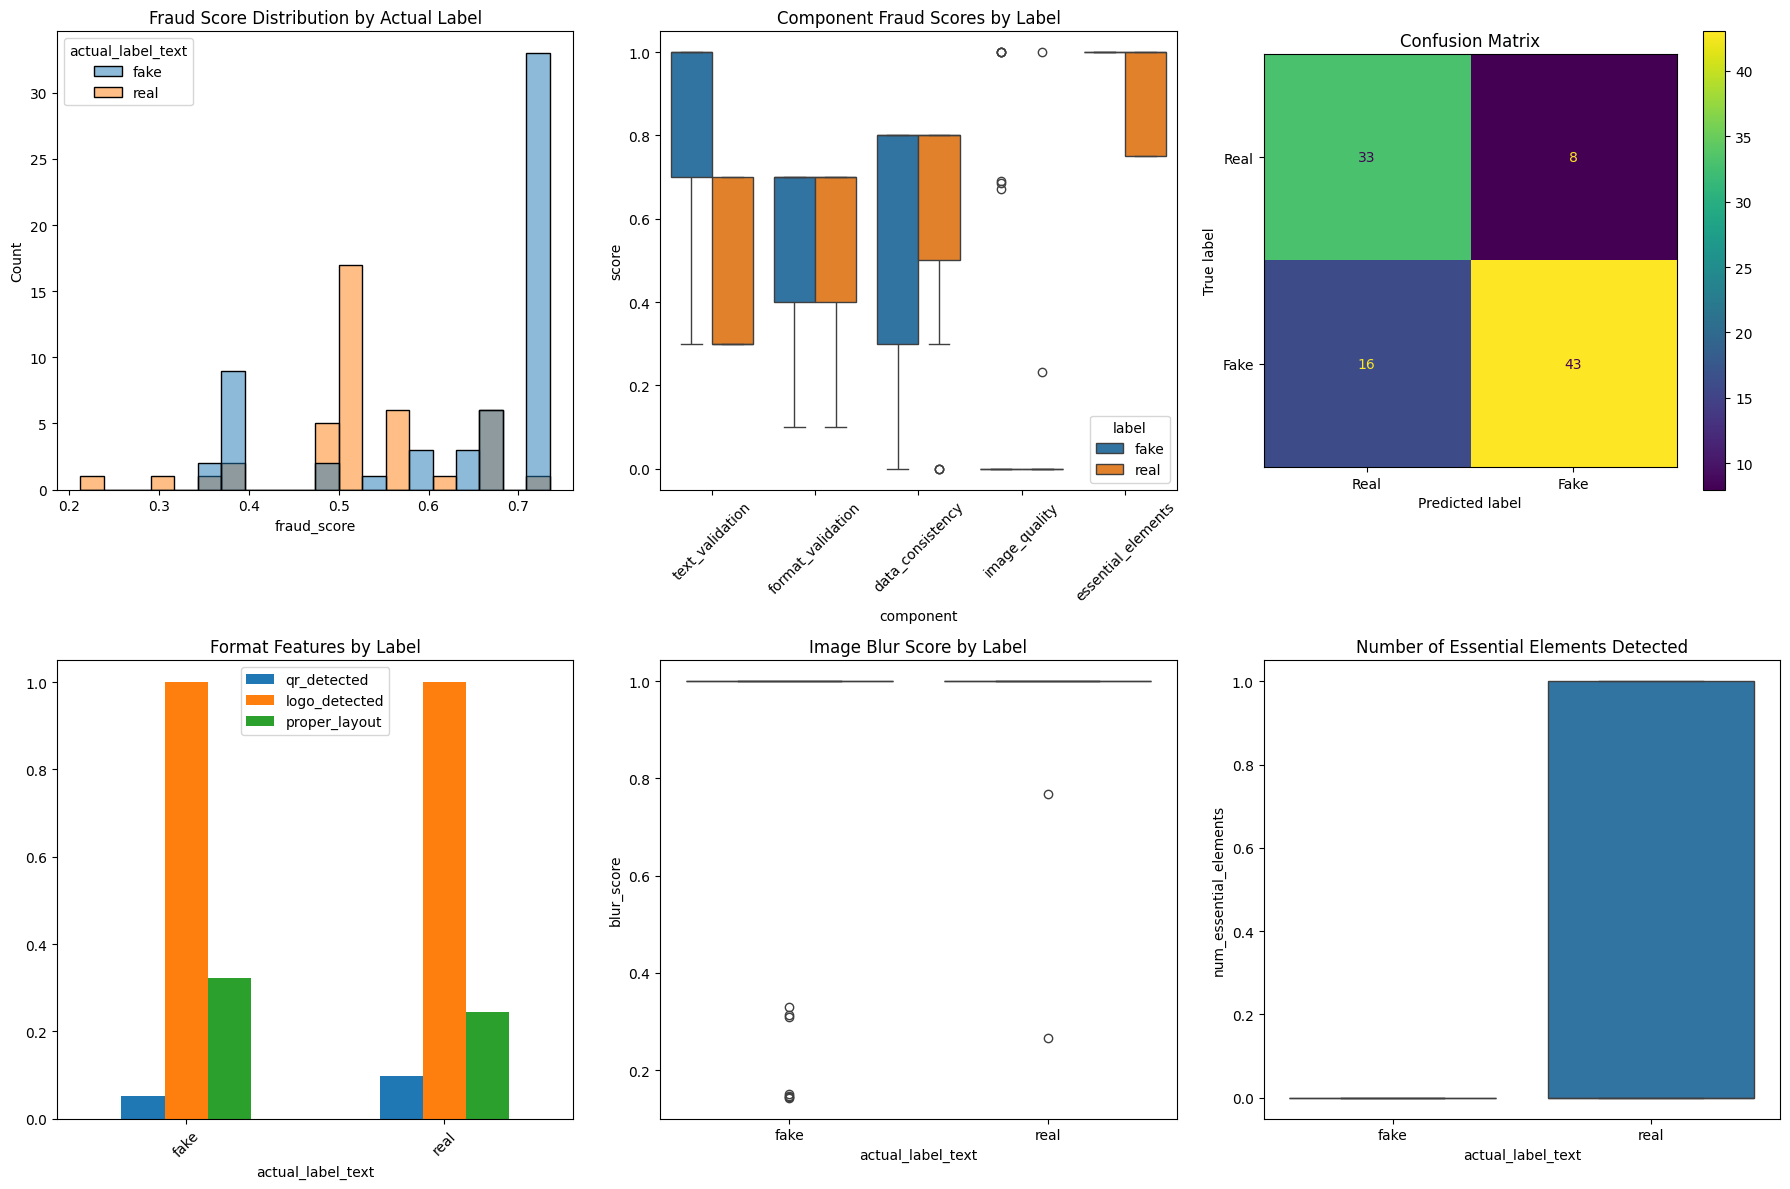

Exporting sample results...
Results exported to /content/aadhaar_fraud_analysis_sample.csv

=== SAMPLE DATA SUMMARY STATISTICS ===
Total Documents Processed: 100
Real Documents: 41
Fake Documents: 59
Overall Accuracy: 76.00%
Precision: 84.31%
Recall: 72.88%

=== KEY FRAUD INDICATORS ===
AADHAAR Number Valid: 37.00%
QR Code Detected: 7.00%
Logo Detected: 100.00%
Proper Layout: 29.00%
Government Text Present: 0.00%
UIDAI Text Present: 2.00%

=== COMPONENT SCORE ANALYSIS ===
       text_validation  format_validation  data_consistency  image_quality  \
label                                                                        
fake          0.798305           0.588136          0.623729       0.102534   
real          0.446341           0.597561          0.648780       0.030051   

       essential_elements  
label                      
fake             1.000000  
real             0.878049  


In [ ]:
# Phase 5: Complete Results & Export (Self-Contained)

print("=== PHASE 5: RESULTS & EXPORT ===")

# First, let's redefine the process_dataset function to ensure it's available
def process_dataset(df, sample_size=None):
    """Process entire dataset and return results"""
    results = []

    # Process sample if specified
    process_df = df.sample(n=sample_size, random_state=42) if sample_size else df

    for idx, row in process_df.iterrows():
        if idx % 50 == 0:
            print(f"Processing image {idx}/{len(process_df)}")

        try:
            # Perform OCR analysis
            ocr_results = ocr_processor.process_aadhaar_document(row['image_path'])

            # Perform format validation
            format_results = format_validator.validate_document_format(row['image_path'])

            # Calculate fraud score
            fraud_results = fraud_detector.calculate_fraud_score(
                ocr_results, format_results, row['image_path'], row['label']
            )

            # Combine all results
            result = {
                'image_name': row['image_name'],
                'image_path': row['image_path'],
                'actual_label': row['label'],
                'actual_label_text': row['label_text'],
                **ocr_results,
                **format_results,
                **fraud_results
            }

            results.append(result)

        except Exception as e:
            print(f"Error processing {row['image_name']}: {e}")
            continue

    return pd.DataFrame(results)

# Now process sample data
print("Processing sample data for visualization...")
sample_results = process_dataset(df, sample_size=100)

print(f"Sample data processed: {len(sample_results)} images")

def create_visualizations(results_df):
    """Create comprehensive visualizations of results"""

    # Create the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Fraud Score Distribution by Actual Label
    if 'fraud_score' in results_df.columns and 'actual_label_text' in results_df.columns:
        sns.histplot(data=results_df, x='fraud_score', hue='actual_label_text',
                     bins=20, ax=axes[0,0])
        axes[0,0].set_title('Fraud Score Distribution by Actual Label')
    else:
        axes[0,0].text(0.5, 0.5, 'Data not available',
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[0,0].transAxes)
        axes[0,0].set_title('Fraud Score Distribution - Data Missing')

    # 2. Component Scores Comparison
    try:
        component_scores = pd.DataFrame(results_df['component_scores'].tolist())
        component_scores['label'] = results_df['actual_label_text']
        component_scores_melted = component_scores.melt(id_vars=['label'],
                                                       var_name='component',
                                                       value_name='score')

        sns.boxplot(data=component_scores_melted, x='component', y='score', hue='label', ax=axes[0,1])
        axes[0,1].set_title('Component Fraud Scores by Label')
        axes[0,1].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[0,1].text(0.5, 0.5, f'Error: {str(e)}',
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[0,1].transAxes)
        axes[0,1].set_title('Component Scores - Error')

    # 3. Confusion Matrix
    try:
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        cm = confusion_matrix(results_df['actual_label'], results_df['final_prediction'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
        disp.plot(ax=axes[0,2])
        axes[0,2].set_title('Confusion Matrix')
    except Exception as e:
        axes[0,2].text(0.5, 0.5, f'Error: {str(e)}',
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[0,2].transAxes)
        axes[0,2].set_title('Confusion Matrix - Error')

    # 4. Format Validation Scores
    try:
        format_features = ['qr_detected', 'logo_detected', 'proper_layout']
        format_summary = results_df[format_features + ['actual_label_text']].groupby('actual_label_text').mean()
        format_summary.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Format Features by Label')
        axes[1,0].tick_params(axis='x', rotation=45)
    except Exception as e:
        axes[1,0].text(0.5, 0.5, f'Error: {str(e)}',
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[1,0].transAxes)
        axes[1,0].set_title('Format Features - Error')

    # 5. Quality Metrics
    try:
        quality_metrics = results_df[['blur_score', 'quality_score', 'actual_label_text']]
        sns.boxplot(data=quality_metrics, x='actual_label_text', y='blur_score', ax=axes[1,1])
        axes[1,1].set_title('Image Blur Score by Label')
    except Exception as e:
        axes[1,1].text(0.5, 0.5, f'Error: {str(e)}',
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[1,1].transAxes)
        axes[1,1].set_title('Quality Metrics - Error')

    # 6. Essential Elements Detection
    try:
        results_df['num_essential_elements'] = results_df['essential_elements_detected'].apply(len)
        sns.boxplot(data=results_df, x='actual_label_text', y='num_essential_elements', ax=axes[1,2])
        axes[1,2].set_title('Number of Essential Elements Detected')
    except Exception as e:
        axes[1,2].text(0.5, 0.5, f'Error: {str(e)}',
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[1,2].transAxes)
        axes[1,2].set_title('Essential Elements - Error')

    plt.tight_layout()
    plt.show()

# Create visualizations
print("Creating visualizations...")
create_visualizations(sample_results)

# Export results to CSV (Local directory)
def export_results(results_df, output_path):
    """Export comprehensive results to CSV"""

    # Create a simplified version for export
    export_df = results_df.copy()

    # Clean up the dataframe for export
    columns_to_export = [
        'image_name', 'actual_label_text', 'fraud_score', 'is_fraudulent',
        'final_prediction', 'correct_prediction', 'aadhaar_valid',
        'has_government_text', 'has_uidai_text', 'qr_detected',
        'logo_detected', 'blur_score', 'quality_score', 'proper_layout',
        'format_score', 'text_length'
    ]

    # Add num_essential_elements if it exists, otherwise calculate it
    if 'num_essential_elements' not in export_df.columns:
        export_df['num_essential_elements'] = export_df['essential_elements_detected'].apply(len)
    columns_to_export.append('num_essential_elements')

    # Add component scores as separate columns
    try:
        component_scores = pd.DataFrame(results_df['component_scores'].tolist())
        component_scores.columns = [f'component_{col}' for col in component_scores.columns]
        export_df = pd.concat([export_df[columns_to_export], component_scores], axis=1)
    except Exception as e:
        print(f"Warning: Could not add component scores: {e}")
        export_df = export_df[columns_to_export]

    # Export to CSV in local directory
    export_df.to_csv(output_path, index=False)
    print(f"Results exported to {output_path}")

    return export_df

# Export sample results to current directory
print("Exporting sample results...")
exported_results = export_results(sample_results, '/content/aadhaar_fraud_analysis_sample.csv')

# Display summary statistics
print("\n=== SAMPLE DATA SUMMARY STATISTICS ===")
print(f"Total Documents Processed: {len(sample_results)}")
print(f"Real Documents: {len(sample_results[sample_results['actual_label'] == 0])}")
print(f"Fake Documents: {len(sample_results[sample_results['actual_label'] == 1])}")

if 'correct_prediction' in sample_results.columns:
    print(f"Overall Accuracy: {sample_results['correct_prediction'].mean():.2%}")

    # Calculate precision and recall
    true_positives = len(sample_results[(sample_results['final_prediction'] == 1) & (sample_results['actual_label'] == 1)])
    false_positives = len(sample_results[(sample_results['final_prediction'] == 1) & (sample_results['actual_label'] == 0)])
    false_negatives = len(sample_results[(sample_results['final_prediction'] == 0) & (sample_results['actual_label'] == 1)])

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")

print("\n=== KEY FRAUD INDICATORS ===")
print(f"AADHAAR Number Valid: {sample_results['aadhaar_valid'].mean():.2%}")
print(f"QR Code Detected: {sample_results['qr_detected'].mean():.2%}")
print(f"Logo Detected: {sample_results['logo_detected'].mean():.2%}")
print(f"Proper Layout: {sample_results['proper_layout'].mean():.2%}")
print(f"Government Text Present: {sample_results['has_government_text'].mean():.2%}")
print(f"UIDAI Text Present: {sample_results['has_uidai_text'].mean():.2%}")

# Show detailed analysis of component scores
print("\n=== COMPONENT SCORE ANALYSIS ===")
try:
    component_df = pd.DataFrame(sample_results['component_scores'].tolist())
    component_df['label'] = sample_results['actual_label_text']
    print(component_df.groupby('label').mean())
except Exception as e:
    print(f"Could not analyze component scores: {e}")

Testing image: /content/Screenshot 2025-10-29 190704.png


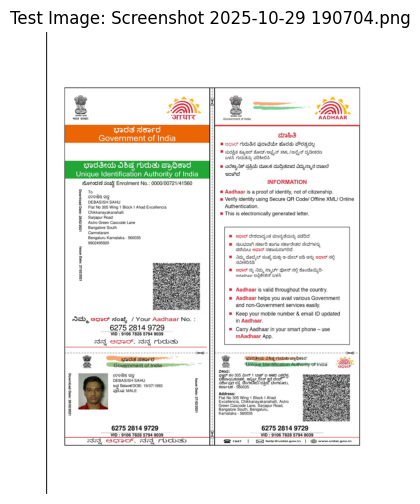

🔍 **IMPROVED ANALYSIS RESULTS:**
📊 Fraud Score: 0.462
🎯 Prediction: ✅ REAL
📈 Confidence: 46.2%

📋 **DETAILED BREAKDOWN:**
   • AADHAAR Number Valid: ✅ Yes
   • QR Code Detected: ✅ Yes
   • Logo Detected: ✅ Yes
   • Proper Layout: ❌ No
   • Image Quality: 1.000
   • Essential Elements Found: 1/4
   • Text Length: 1320 characters
   • AADHAAR Number: 627528149729

📝 **EXTRACTED TEXT SAMPLE:**
IED

AN.

=

g

ores

To

3 — A.

SS

RADHAAR

abs

seca rhb goadabe tach ag

1 Rs age deere OU Jory esses

ok ross 2

1 ace 2e oo es ans ys

cov

‘rcociet oa Ervalment No.:0000'00721/41560,

INFORMAT...


(np.float64(0.46249999999999997), np.False_)

In [ ]:
# Update the test_single_image function to use improved processors
def test_single_image_improved(image_path):
    """
    Test a single AADHAAR image using improved algorithms
    """
    print(f"Testing image: {image_path}")
    print("=" * 50)

    try:
        if not os.path.exists(image_path):
            print(f"❌ Error: File not found at {image_path}")
            return

        # Use IMPROVED processors
        ocr_results = improved_ocr_processor.process_aadhaar_document_improved(image_path)
        format_results = format_validator.validate_document_format(image_path)

        # Update format results with improved QR detection
        format_results['qr_detected'] = detect_qr_improved(image_path)

        fraud_results = fraud_detector.calculate_fraud_score(ocr_results, format_results, image_path)

        # Display the image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Test Image: {os.path.basename(image_path)}")
        plt.show()

        # Display results
        fraud_score = fraud_results['fraud_score']
        is_fraudulent = fraud_results['is_fraudulent']

        print("🔍 **IMPROVED ANALYSIS RESULTS:**")
        print(f"📊 Fraud Score: {fraud_score:.3f}")
        print(f"🎯 Prediction: {'❌ FAKE' if is_fraudulent else '✅ REAL'}")
        print(f"📈 Confidence: {fraud_score:.1%}")

        print("\n📋 **DETAILED BREAKDOWN:**")
        print(f"   • AADHAAR Number Valid: {'✅ Yes' if ocr_results['aadhaar_valid'] else '❌ No'}")
        print(f"   • QR Code Detected: {'✅ Yes' if format_results['qr_detected'] else '❌ No'}")
        print(f"   • Logo Detected: {'✅ Yes' if format_results['logo_detected'] else '❌ No'}")
        print(f"   • Proper Layout: {'✅ Yes' if format_results['proper_layout'] else '❌ No'}")
        print(f"   • Image Quality: {format_results['quality_score']:.3f}")
        print(f"   • Essential Elements Found: {len(ocr_results['essential_elements_detected'])}/4")
        print(f"   • Text Length: {ocr_results['text_length']} characters")
        print(f"   • AADHAAR Number: {ocr_results['aadhaar_number']}")

        print("\n📝 **EXTRACTED TEXT SAMPLE:**")
        print(ocr_results['raw_text'][:200] + "..." if len(ocr_results['raw_text']) > 200 else ocr_results['raw_text'])

        return fraud_score, is_fraudulent

    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None, None

# Test with your image using improved version
test_single_image_improved("/content/Screenshot 2025-10-29 190704.png")